In [37]:
import numpy as np 
import pandas as pd 


In [38]:
import matplotlib.pyplot as plt
import os

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string
from string import punctuation

import re

In [39]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sentiments = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [40]:
data = pd.read_csv('Ana Blackadam trailer comments.csv')
data.columns

Index(['Unnamed: 0', 'Comment', 'Likes', 'Time', 'user', 'UserLink'], dtype='object')

In [41]:
data.head()

,Unnamed: 0,Comment,Likes,Time,user,UserLink
0,0,Love how Dr. Fate's design looks and how cool ...,12K,9 days ago,NaN,NaN
1,1,I can’t get over how good everything looks. Dr...,2.6K,7 days ago,NaN,NaN
2,2,Really hoping that this can save DC's movie un...,814,7 days ago,NaN,NaN
3,3,U cant deny how good this looks.Now if they ca...,91,6 days ago,NaN,NaN
4,4,"From this trailer, I have a feeling that this ...",367,7 days ago (edited),NaN,NaN


In [42]:
data1=data.drop(['Unnamed: 0','Likes','Time','user','UserLink'],axis=1)
data1

,Comment
0,Love how Dr. Fate's design looks and how cool ...
1,I can’t get over how good everything looks. Dr...
2,Really hoping that this can save DC's movie un...
3,U cant deny how good this looks.Now if they ca...
4,"From this trailer, I have a feeling that this ..."
...,...
275,I want to see this. It may be one of his most ...
276,wow thats very amazing. I can't wait to see.
277,Doctor Fate is why i'm watching
278,This looks fire. DC looks like they stepping t...


* **Data transformation**

In [43]:
stop_words=set(stopwords.words('english'))
lzr = WordNetLemmatizer()

In [44]:
def text_processing(text):   
    # convert text into lowercase
    text = text.lower()

    # remove new line characters in text
    text = re.sub(r'\n',' ', text)
    
    # remove punctuations from text
    text = re.sub('[%s]' % re.escape(punctuation), "", text)
    
    # remove references and hashtags from text
    text = re.sub("^a-zA-Z0-9$,.", "", text)
    
    # remove multiple spaces from text
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # remove special characters from text
    text = re.sub(r'\W', ' ', text)

    text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
    
    text=' '.join([lzr.lemmatize(word) for word in word_tokenize(text)])

    return text

In [45]:
nltk.download('omw-1.4')
data_copy = data1.copy()
data_copy.Comment = data_copy.Comment.apply(text_processing)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [46]:

sentiments = SentimentIntensityAnalyzer()
data_copy["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data_copy["Comment"]]
data_copy["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data_copy["Comment"]]
data_copy["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data_copy["Comment"]]
data_copy['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in data_copy["Comment"]]
score = data_copy["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
data_copy["Sentiment"] = sentiment

In [47]:
data_copy.head()

,Comment,Positive,Negative,Neutral,Compound,Sentiment
0,love dr fate design look cool scene look power...,0.515,0.000,0.485,0.8910,Positive
1,get good everything look dr fate magic cyclone...,0.218,0.000,0.782,0.6486,Positive
2,really hoping save dc movie universe looking n...,0.490,0.000,0.510,0.9256,Positive
3,u cant deny good looksnow follow rest movie go...,0.425,0.071,0.504,0.9174,Positive
4,trailer feeling movie going one movie would ne...,0.303,0.000,0.697,0.4416,Positive


* **Final data**

In [48]:
data2=data_copy.drop(['Positive','Negative','Neutral','Compound'],axis=1)
data2.head()

,Comment,Sentiment
0,love dr fate design look cool scene look power...,Positive
1,get good everything look dr fate magic cyclone...,Positive
2,really hoping save dc movie universe looking n...,Positive
3,u cant deny good looksnow follow rest movie go...,Positive
4,trailer feeling movie going one movie would ne...,Positive


In [49]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_copy['Sentiment'] = le.fit_transform(data_copy['Sentiment'])

In [50]:
processed_data = {
    'Sentence':data_copy.Comment,
    'Sentiment':data_copy['Sentiment']
}
processed_data = pd.DataFrame(processed_data)
processed_data.head()

,Sentence,Sentiment
0,love dr fate design look cool scene look power...,2
1,get good everything look dr fate magic cyclone...,2
2,really hoping save dc movie universe looking n...,2
3,u cant deny good looksnow follow rest movie go...,2
4,trailer feeling movie going one movie would ne...,2


In [51]:
processed_data['Sentiment'].value_counts()

2    211
1     38
0     31
Name: Sentiment, dtype: int64

In [52]:
from sklearn.utils import resample
df_neutral = processed_data[(processed_data['Sentiment']==1)] 
df_negative = processed_data[(processed_data['Sentiment']==0)]
df_positive = processed_data[(processed_data['Sentiment']==2)]

# upsample minority classes
df_negative_upsampled = resample(df_negative, 
                                 replace=True,    
                                 n_samples= 211, 
                                 random_state=42)  

df_neutral_upsampled = resample(df_neutral, 
                                 replace=True,    
                                 n_samples= 211, 
                                 random_state=42)  


# Concatenate the upsampled dataframes with the neutral dataframe
final_data = pd.concat([df_negative_upsampled,df_neutral_upsampled,df_positive])

In [53]:
final_data['Sentiment'].value_counts()

0    211
1    211
2    211
Name: Sentiment, dtype: int64

In [54]:
final_data.head(20)

,Sentence,Sentiment
51,im sure ive seen hawkman change head mace comi...,0
148,1 really hope black adam fighting style straig...,0
257,man future dc mcu gunna serious competition,0
99,need fight superman shazam,0
85,love making villain film villain film,0
58,magic weak line gave chillsdwayne gon na kill ...,0
257,man future dc mcu gunna serious competition,0
157,cant wait hope good trailer,0
51,im sure ive seen hawkman change head mace comi...,0
190,trailer look sick im definitely watching movie,0


In [55]:
corpus = []
for sentence in final_data['Sentence']:
    corpus.append(sentence)
corpus[0:5]

['im sure ive seen hawkman change head mace comic looking litthen black adam scene magic weak really got',
 '1 really hope black adam fighting style straightforward direct appears trailer2 retractable helmet black hawkman extremely stupid mechanical working mace reminds mcu hoguns mace needle want change physical appearance',
 'man future dc mcu gunna serious competition',
 'need fight superman shazam',
 'love making villain film villain film']

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(corpus).toarray()
y = final_data.iloc[:, -1].values

## Machine Learning Model 

In [58]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

* **Evaluation**

In [59]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[59,  3,  0],
       [ 0, 61,  1],
       [ 9,  0, 57]], dtype=int64)

In [60]:
nb_score = accuracy_score(y_test, y_pred)
print('accuracy',nb_score)

accuracy 0.9315789473684211


In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91        62
           1       0.95      0.98      0.97        62
           2       0.98      0.86      0.92        66

    accuracy                           0.93       190
   macro avg       0.93      0.93      0.93       190
weighted avg       0.94      0.93      0.93       190



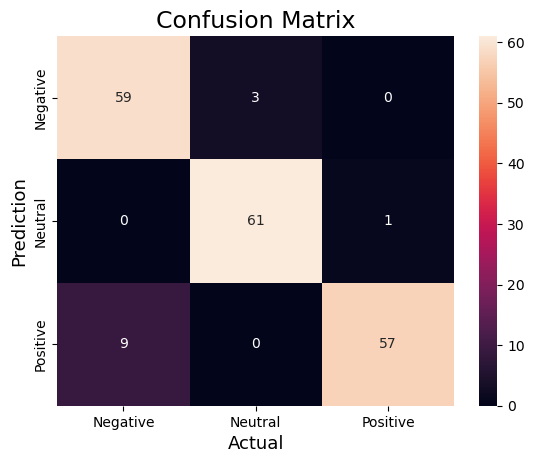

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Negative','Neutral','Positive'],
            yticklabels=['Negative','Neutral','Positive'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
